In [59]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
import math

# 1. 数据准备：data file -> dataloader

In [44]:
# 获取序列的失效索引
def get_failure_idx(seq, threshold):
    indices = (seq <= threshold).nonzero()[0]
    if indices.size > 0:
        return indices[0]
    return float('nan')

# 读取数据：data_file(.npy) -> norm_sequence_data, failure_time
def read_and_norm(data_path, rated_capacity=1.1, failure_threshold=0.7):
    data = np.load(data_path, allow_pickle=True).item()
    # 标准化：对 capacity 数组整体除以额定容量
    norm_data = {battery_name: df['capacity'].values / rated_capacity for battery_name, df in data.items()}
    # 计算失效时间
    failure_time = {}  
    for battery, data in norm_data.items():
        failure_time[battery] = get_failure_idx(data, failure_threshold) + 1
    return norm_data, failure_time

# 数据划分：battery_data（字典） -> train_data, test_data
def split_data(battery_data, test_battery_name):
    train_data = {name: data for name, data in battery_data.items() if name != test_battery_name}
    test_data = battery_data[test_battery_name]
    return train_data, test_data

# 滑动窗口生成样本：sequence_data ->（sequences，labels）
def create_sequences(data, window_size=64):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append(sequence)
        labels.append(label)
    return sequences, labels

# （sequences，labels）-> Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        if isinstance(sequences, list):  # 判断是否为列表类型
            sequences = np.array(sequences)  # 如果是列表，则转换为 numpy 数组，加速tensor的转化
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# 数据准备（全过程）：data_file(.npy) -> Dataloader
def load_data(test_battery_name, data_path, rated_capacity=1.1, window_size=64, batch_size=32, failure_threshold=0.7, **kwargs):
    # 数据读取、标准化
    battery_data, _ = read_and_norm(data_path=data_path, rated_capacity=rated_capacity, failure_threshold=failure_threshold)

    # 数据集划分：选择一个电池作为测试集，其余为训练集
    train_data, test_data = split_data(battery_data=battery_data, test_battery_name=test_battery_name)

    # 滑动窗口：生成序列数据样本和标签
    train_sequences, train_labels = [], []
    for _, data in train_data.items():
        sequences, labels = create_sequences(data, window_size=window_size)
        train_sequences.extend(sequences)
        train_labels.extend(labels)
    test_sequences, test_labels = create_sequences(test_data, window_size=window_size)

    # 创建 DataLoader
    train_dataset = TimeSeriesDataset(train_sequences, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TimeSeriesDataset(test_sequences, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# 2. 模型

In [45]:
# LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size1=50, hidden_size2=100, output_size=1, dropout=0.5, **kwargs):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # 设置 Dropout 层
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2, batch_first=True)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout(out)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [46]:
# GRU
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout, **kwargs):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

In [90]:
# DeTransformer
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.01, **kwargs):
        '''
        Args:
            input_size: the feature size of input data (required).
            hidden_dim: the hidden size of AutoEncoder (required).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Autoencoder, self).__init__()
        self.noise_level = noise_level
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_size)
        
    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1
    
    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x
    
    def decoder(self, x):
        h2 = self.fc2(x)
        return h2
    
    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, feature_len, feature_size, dropout=0.0):
        '''
        Args:
            feature_len: the feature length of input data (required).
            feature_size: the feature size of input data (required).
            dropout: the dropout rate (optional).
        '''
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(feature_len, feature_size)
        position = torch.arange(0, feature_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, feature_size, 2).float() * (-math.log(10000.0) / feature_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe
        
        return x
    

class DeTransformer(nn.Module):
    def __init__(self, feature_size=64, hidden_dim=32, feature_num=1, num_layers=1, nhead=1, dropout=0.0, noise_level=0.01, **kwargs):
        '''
        Args:
            feature_size: the feature size of input data (required).
            hidden_dim: the hidden size of Transformer block (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(DeTransformer, self).__init__()
        self.auto_hidden = int(feature_size / 2)
        input_size = self.auto_hidden
        
        if feature_num == 1:
            # Transformer treated as an Encoder when modeling for a sigle feature like only capacity data
            self.pos = PositionalEncoding(feature_len=feature_num, feature_size=input_size)
            encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        elif feature_num > 1:
            # Transformer treated as a sequence model when modeling for multi-features like capacity, voltage, and current data
            self.pos = PositionalEncoding(feature_len=input_size, feature_size=feature_num)
            encoder_layers = nn.TransformerEncoderLayer(d_model=feature_num, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.linear = nn.Linear(feature_num*self.auto_hidden, 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)
 
    def forward(self, x): 
        batch_size, feature_num, feature_size  = x.shape
        out, decode = self.autoencoder(x)
        if feature_num > 1:
            out = out.reshape(batch_size, -1, feature_num)
        out = self.pos(out)
        out = self.cell(out)              # sigle feature: (batch_size, feature_num, auto_hidden) or multi-features: (batch_size, auto_hidden, feature_num)
        out = out.reshape(batch_size, -1) # (batch_size, feature_num*auto_hidden)
        out = self.linear(out)            # out shape: (batch_size, 1)
        
        return out, decode

# 3. 训练

## 3.1 参数设置

## 3.2 训练：输出训练好的模型文件

In [48]:
def get_model_and_optim(model_name, all_config):
    local_config = all_config[model_name]
    if model_name == 'LSTM':
        model = LSTM(**local_config)
        optimizer = optim.RMSprop(model.parameters(), local_config['lr'], local_config['alpha'])
    elif model_name == 'GRU':
        model = GRU(**local_config)
        optimizer = optim.Adam(model.parameters(), local_config['lr'])
    elif model_name == 'DeTransformer':
        model = DeTransformer(**local_config)
        optimizer = optim.Adam(model.parameters(), local_config['lr'])
    else:
        print("Error: 没有这个模型")
        sys.exit(1)  # 退出程序，状态码 1 表示异常
    model.to(device=local_config['device'])
    return model, optimizer

In [111]:
def forward_prop(model_name, model, x, all_config):
    local_config = all_config['DeTransformer']
    decodes = None
    if model_name == 'DeTransformer':
        x = x.unsqueeze(-1).permute(0, 2, 1).repeat(1, local_config['K'], 1)
        outputs, decodes = model(x)
    else:
        outputs = model(x.unsqueeze(-1))

    return outputs, decodes

def get_loss(model_name, model, x, y, criterion, all_config):
    local_config = all_config['DeTransformer']
    outputs, decodes = forward_prop(model_name, model, x, all_config)
    loss = criterion(outputs, y.unsqueeze(-1))
    return loss if decodes is None else loss + local_config['alpha'] * criterion(
        x.unsqueeze(-1).permute(0, 2, 1).repeat(1, local_config['K'], 1), decodes
        )

# 训练
def train(model_name, all_config):
    config = all_config[model_name]
    num_epochs = config['num_epochs']
    device = config['device']

    # 数据准备
    train_loader, test_loader = load_data(**config)

    # 获取初始化的模型、优化器
    model, optimizer= get_model_and_optim(model_name, all_config)
    criterion = nn.MSELoss()

    # 训练循环
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')  # 初始化一个较大的损失值
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = get_loss(model_name, model, sequences, labels, criterion, all_config)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # 记录训练损失

        # 测试
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                test_loss += get_loss(model_name, model, sequences, labels, criterion, all_config).item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)  # 记录测试损失
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}")

        # 保存测试损失最低的模型
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), f'checkpoints/{model_name}.pth')
            print(f"New best model saved")

# 4. 测试：模型文件 -> 测试结果（评价指标、预测曲线）

## 4.1 预测：模型文件 -> 预测序列

In [97]:
def predict(model_name, model, start_idx, actual_seq, window_size, device, all_config):
    with torch.no_grad():
        num_preds = len(actual_seq) - start_idx  # 让预测曲线与真实曲线同时结束
        preds = actual_seq[start_idx - window_size:start_idx]
        for _ in range(num_preds):
            input_seq = torch.tensor(preds[-window_size:], dtype=torch.float32).to(device).unsqueeze(0)
            pred, _ = forward_prop(model_name, model, input_seq, all_config)
            preds = np.append(preds, pred.item())
    return preds[window_size:]

def test(model_name, all_config):
    # 超参数
    config = all_config[model_name]

    # 加载模型
    model, _ = get_model_and_optim(model_name, all_config)
    model.load_state_dict(torch.load(f'checkpoints/{model_name}.pth', weights_only=True))
    model.eval()  # 设置模型为评估模式

    # 获取真实值序列
    battery_data, failure_time = read_and_norm(config['data_path'])
    actual_seq = battery_data[config['test_battery_name']]

    # 获取预测起始点，迭代预测
    start_idx = int(failure_time[config['test_battery_name']] * config['start_point'])
    pred_seq = predict(model_name, model, start_idx, actual_seq, config['window_size'], config['device'], all_config)

    return actual_seq, pred_seq, start_idx

## 4.2 Evaluate & Plot

In [115]:
def cal_metrics(actual_seq, pred_seq, start_idx, failure_threshold=0.7):
    # RE
    actual_failure_idx = get_failure_idx(actual_seq, failure_threshold)
    pred_failure_idx = get_failure_idx(pred_seq, failure_threshold) + start_idx
    re = abs(actual_failure_idx - pred_failure_idx) / (actual_failure_idx + 1)
    # RMSE
    rmse = np.sqrt(np.mean((actual_seq[start_idx:] - pred_seq) ** 2))    
    # MAE
    mae = np.mean(np.abs(actual_seq[start_idx:] - pred_seq))
    return re, rmse, mae

# 绘制曲线
def plot(model_names, actual_seq, pred_seqs, start_idx, failure_threshold=0.7, test_battery_name='CS2_35'):
    colors = ['blue', 'green', 'orange', 'purple']
    plt.figure(figsize=(12, 6))
    for i in range(len(pred_seqs)):
        plt.plot(range(start_idx, len(pred_seqs[i]) + start_idx), pred_seqs[i], color=colors[i], linestyle='--', linewidth=2, label=model_names[i])  # 预测值曲线
    plt.plot(actual_seq, color='darkblue', linestyle='-', linewidth=1.5, label='Actual SOH')  # 真实值曲线
    plt.axhline(y=failure_threshold, color='red', linestyle='--', linewidth=2.5, label='Failure Threshold')  # 失效阈值线
    plt.axvline(x=start_idx, color='gray', linestyle='--', linewidth=1, label='Prediction Start Point')  # 预测起始点

    plt.xlabel('Cycles')
    plt.ylabel('SOH')
    plt.legend()
    plt.title(f'SOH degredation of {test_battery_name}')
    plt.show()

def eval_and_plot(model_names, all_config):
    local_config = all_config[model_names[0]]
    failure_threshold = local_config['failure_threshold']
    test_battery_name = local_config['test_battery_name']
    pred_seqs = []
    for model_name in model_names:
        actual_seq, pred_seq, start_idx = test(model_name, all_config)
        
        # 计算RE、RMSE、MAE
        re, rmse, mae = cal_metrics(actual_seq, pred_seq, start_idx)
        print(f"Model:{model_name}, RE: {re:.3f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

        pred_seqs.append(pred_seq)

    plot(model_names, actual_seq, pred_seqs, start_idx, failure_threshold, test_battery_name)

In [117]:
all_config = {
    "LSTM": {
        # 模型参数
        "input_size": 1,
        "hidden_size1": 50,
        "hidden_size2": 100,
        "output_size": 1,
        "dropout": 0.8,
        
        # 训练参数
        "batch_size": 32,
        "lr": 1e-3,
        "alpha": 0.99,
        "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        "num_epochs": 200,
        
        # 数据处理参数
        "window_size": 64,
        "data_path": "data/CALCE/CALCE.npy",
        "test_battery_name": "CS2_35",
        "rated_capacity": 1.1,
        "failure_threshold": 0.7,
        'start_point': 0.5
    },
    
    "GRU": {
        # 模型参数
        "input_size": 1,
        "hidden_size": 64,
        "output_size": 1,
        "num_layers": 4,
        "dropout": 0.5,
        
        # 训练参数
        "batch_size": 32,
        "lr": 1e-3,
        "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        "num_epochs": 200,
        
        # 数据处理参数
        "window_size": 64,
        "data_path": "data/CALCE/CALCE.npy",
        "test_battery_name": "CS2_35",
        "rated_capacity": 1.1,
        "failure_threshold": 0.7,
        'start_point': 0.5
    },
    
    "DeTransformer": {
        # 模型参数
        "feature_size": 64,
        "hidden_dim": 32,
        "feature_num": 16,
        "hidden_dim": 16,
        "num_layers": 3,
        "nhead": 1,
        "dropout": 1e-3,
        "noise_level": 0.01,
        "alpha": 0.1,
        
        # 训练参数
        "batch_size": 32,
        "lr": 1e-3,
        "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        "num_epochs": 200,
        
        # 数据处理参数
        "K": 16,  # 输入的特征维度的repeat次数
        "window_size": 64,
        "data_path": "data/CALCE/CALCE.npy",
        "test_battery_name": "CS2_35",
        "rated_capacity": 1.1,
        "failure_threshold": 0.7,
        'start_point': 0.5
    }
}

In [113]:
# model_name = 'GRU'
model_name = 'LSTM'
train(model_name, all_config)

Epoch [1/200], Training Loss: 0.04469347, Test Loss: 0.00664353
New best model saved
Epoch [2/200], Training Loss: 0.00435868, Test Loss: 0.00475202
New best model saved
Epoch [3/200], Training Loss: 0.00421072, Test Loss: 0.00206085
New best model saved
Epoch [4/200], Training Loss: 0.00329710, Test Loss: 0.00107182
New best model saved
Epoch [5/200], Training Loss: 0.00297014, Test Loss: 0.00141220
Epoch [6/200], Training Loss: 0.00255588, Test Loss: 0.00116793
Epoch [7/200], Training Loss: 0.00266096, Test Loss: 0.00138324
Epoch [8/200], Training Loss: 0.00228576, Test Loss: 0.01173077
Epoch [9/200], Training Loss: 0.00230772, Test Loss: 0.00119248
Epoch [10/200], Training Loss: 0.00190810, Test Loss: 0.00109228
Epoch [11/200], Training Loss: 0.00181522, Test Loss: 0.00064725
New best model saved
Epoch [12/200], Training Loss: 0.00171135, Test Loss: 0.00220931
Epoch [13/200], Training Loss: 0.00136400, Test Loss: 0.00299674
Epoch [14/200], Training Loss: 0.00170322, Test Loss: 0.001

KeyboardInterrupt: 

Model:LSTM, RE: nan, RMSE: 0.2681, MAE: 0.1898
Model:GRU, RE: 0.253, RMSE: 0.2947, MAE: 0.2592


/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model:DeTransformer, RE: 0.022, RMSE: 0.0376, MAE: 0.0326


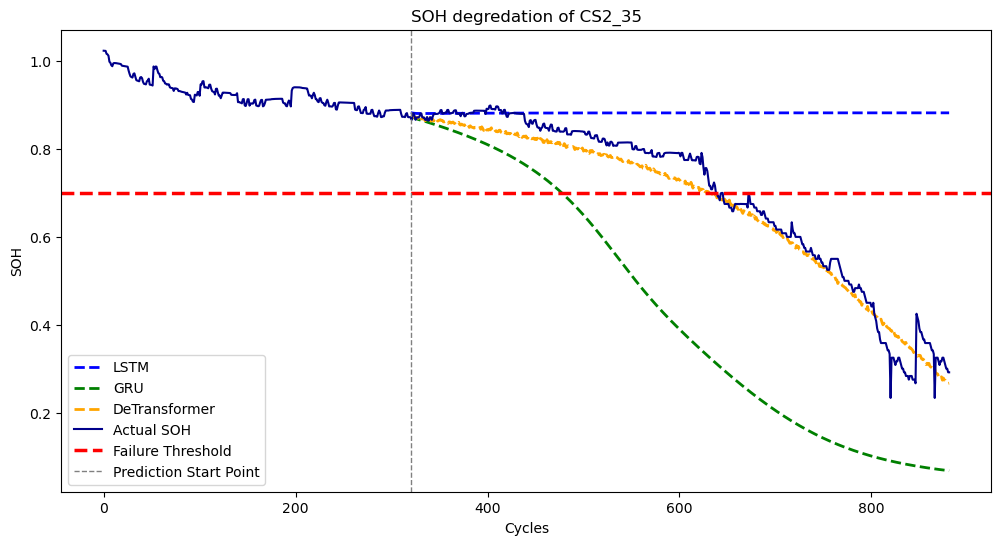

In [118]:
model_names = ['LSTM', 'GRU', 'DeTransformer']
eval_and_plot(model_names, all_config)

0.010246846362455986


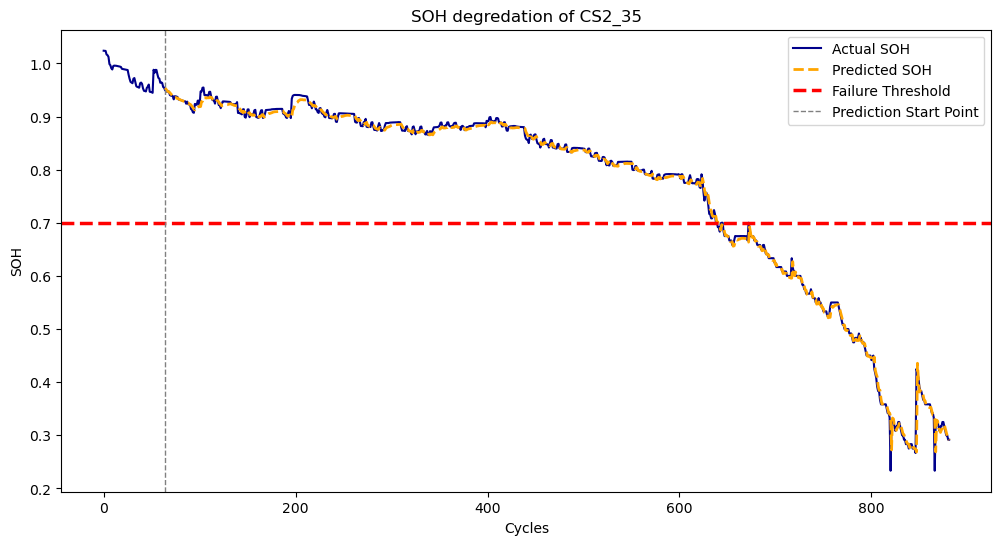

In [52]:
# model_name = 'GRU'
# 超参数
config = all_config[model_name]

actual_seq = split_data(read_and_norm(config['data_path'])[0], config['test_battery_name'])[1]

# 加载模型
model, _ = get_model_and_optim(model_name, all_config)
model.load_state_dict(torch.load(f'checkpoints/{model_name}.pth', weights_only=True))
model.eval()  # 设置模型为评估模式

_, test_loader = load_data(**config)
device = config['device']
criterion = nn.MSELoss()
window_size = config['window_size']
# test_loss = 0

res = []
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences.unsqueeze(-1))
        res.extend(outputs.flatten().tolist())

# 计算RMSE
_, rmse, _ = cal_metrics(actual_seq, np.array(res), window_size)
print(rmse)
# 画真实曲线和预测曲线
plot(actual_seq, np.array(res), window_size)
#         test_loss += criterion(outputs, labels.unsqueeze(-1)).item()
# test_loss /= len(test_loader)
# print(test_loss)